In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import random
import glob
import pickle
import os
from tqdm import tqdm
from IPython.display import display, HTML

import re
import regex
import nltk
from nltk.tokenize import TreebankWordTokenizer, WhitespaceTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
class MyTokenizer:
    def tokenize(self, text):
        tokenizer = TreebankWordTokenizer()
        result = []
        word = r"\p{letter}"
        for sent in nltk.sent_tokenize(text):
            tokens = tokenizer.tokenize(sent)
            tokens = [t for t in tokens if regex.search(word, t)]
            result += tokens
        return result
    
def termstats(dtm, vectorizer):
    frequencies = dtm.sum(axis=0).tolist()[0]
    docfreqs = np.bincount(dtm.indices)
    freq_df = pd.DataFrame(
        dict(frequency=frequencies, docfreq=docfreqs),
        index=vectorizer.get_feature_names_out()
    )
    res = freq_df.sort_values("frequency", ascending=False)
    return res

def docs_containing_token(token, cv, dtm, data, return_index=False):
    try:
        dtm_row_index = []
        for t in token:
            token_index = cv.vocabulary_[t]
            dtm_row_index_token = dtm.getcol(token_index).nonzero()[0].tolist()
            dtm_row_index.extend(dtm_row_index_token)
        dtm_row_index = list(set(dtm_row_index))
        data_containing_token = [data[i] for i in dtm_row_index]
    except:
        if token not in cv.vocabulary_.keys():
            print("Token not in vocabulary.")
            return
        token_index = cv.vocabulary_[token]
        dtm_row_index = dtm.getcol(token_index).nonzero()[0]
        data_containing_token = [data[i] for i in dtm_row_index]
    if return_index:
        return dtm_row_index
    else:
        return data_containing_token
    
def year_aggregate(paper_df, colskip):
    year_dict = {"year":[], "conference": [], "paper_total": []}
    for col in paper_df.columns[colskip:]:
        col_name_total = col+"_total"
        col_name_share = col+"_share"
        year_dict[col_name_total] = []
        year_dict[col_name_share] = []

    year_group = paper_df.groupby("year")
    years = year_group.groups.keys()
    for y in years:
        year_snippet = year_group.get_group(y)
        conf_group = year_snippet.groupby("conference")
        confs = conf_group.groups.keys()
        for c in confs:
            year_dict["year"].append(y)
            year_dict["conference"].append(c)
            conf_snippet = conf_group.get_group(c)
            paper_total_conf_year = conf_snippet.shape[0]
            year_dict["paper_total"].append(paper_total_conf_year)
            for col in conf_snippet.columns[colskip:]:
                col_share = sum(conf_snippet[col])/paper_total_conf_year
                col_name_total = col+"_total"
                col_name_share = col+"_share"
                year_dict[col_name_total].append(sum(conf_snippet[col]))
                year_dict[col_name_share].append(col_share)
    return year_dict

def dtm_to_token_lists(dtm, cv):
    token_list = []
    rows = dtm.shape[0]
    for row_index in range(rows):
        row_non_zero = dtm.getrow(row_index).nonzero()[1]
        tokens = cv.get_feature_names_out()[row_non_zero]
        tokens = [str(t) for t in tokens]
        token_list.append(tokens)
    return token_list

mytokenizer = MyTokenizer()

In [3]:
scratch_path = "/Users/tildralle/Skripts/towards_ethic_in_snp/data/papers"
scratch_path_ocr = "/Users/tildralle/Skripts/towards_ethic_in_snp/data/papers_ocr"

dpaths = glob.glob(scratch_path+"/*/*/*.json")
dpaths_ocr = glob.glob(scratch_path_ocr+"/*/*/*.json")

years_ocr_use = np.arange(1980, 2000,1).astype(str)

dpaths_to_use = [dp for dp in dpaths if not dp.split("/")[-2] in years_ocr_use]
dpaths_ocr_to_use = [dp for dp in dpaths_ocr if dp.split("/")[-2] in years_ocr_use]

paths = dpaths_ocr_to_use + dpaths_to_use

data = []
for dp in paths:
    with open(dp, "r") as f:
        d = json.load(f)
        data.append(d)

data_to_use = data
paths_to_use = paths

conf_list = []
year_list = []
title_list = []
for dp in paths_to_use:
    pathsplit = dp.split("/")
    conf = pathsplit[-3]
    year = int(pathsplit[-2])
    title = pathsplit[-1][:-5]
    conf_list.append(conf)
    year_list.append(year)
    title_list.append(title)

paper_dict = {"conference": conf_list, "year": year_list, "title": title_list, "text": [], "headings": [], "split_text": []}

for d in data_to_use:
    content = {"label": [], "text": []}

    groups = d["groups"]
    groups_refs = [g["self_ref"] for g in groups]
    texts = d["texts"]

    legal_labels = ["text", "list_item", "list"]

    for t in texts:
        parent = t["parent"]["$ref"]
        if parent == "#/body":
            if t["label"] == "section_header":
                content["label"].append(0) # 0 for headings, 1 for normal text
                content["text"].append(t["text"])
            elif t["label"] in legal_labels:
                content["label"].append(1) 
                content["text"].append(t["text"])
        elif parent in groups_refs:
            group_index = groups_refs.index(parent)
            group = groups[group_index]
            if group["label"] in legal_labels:
                content["label"].append(1)
                content["text"].append(t["text"])

    text = " ".join(content["text"])
    headings = [text for label, text in zip(content["label"], content["text"]) if label == 0]
    split_index = [i+1 for i, label in enumerate(content["label"]) if label == 0]
    split_index.append(len(content["label"])+1)
    split_text = [content["text"][split_index[i]:split_index[i+1]-1] for i in range(len(split_index)-1)]
    split_text = [" ".join(t) for t in split_text]
    paper_dict["text"].append(text)
    paper_dict["headings"].append(headings)
    paper_dict["split_text"].append(split_text)

# Remove references

for n, headings in enumerate(paper_dict["headings"]):
    for k, h in enumerate(headings):
        if h.lower() == "references":
            paper_dict["text"][n] = paper_dict["text"][n].replace(paper_dict["split_text"][n][k], "")
            paper_dict["headings"][n].pop(k)
            paper_dict["split_text"][n].pop(k)

In [ ]:
general_ethics_keys = ['review board', 'institutional review', 'board irb', 'ethical considerations', 'ethics committee', 'ethical concerns', 'irb approval', 'ethical issues', 'institution irb', 'ethical implications', 'ethical principles', 'ethical frameworks', 'menlo report', 'public interest', 'board erb', 'belmont report']

human_subject_keys = ['consent form', 'explicit consent', 'human subjects', 'real users', 'involve human']

botnet_keys = ["botnet", "infected machines", "infected hosts"]

key_list = [general_ethics_keys, human_subject_keys, botnet_keys]


In [5]:
load_pickle = True

if load_pickle:
    cv = pickle.load(open("vectorizer_and_dtm/count_vectorizer.pkl", "rb"))
    dtm = pickle.load(open("vectorizer_and_dtm/dtm.pkl", "rb"))
else:
    additional_stopwords = ["'d", "'ll", "'m", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would']
    my_stopwords = stopwords.words("english") + additional_stopwords
    cv = CountVectorizer(ngram_range=(1,2),stop_words=my_stopwords,tokenizer=mytokenizer.tokenize)
    dtm = cv.fit_transform(paper_dict["text"])

In [11]:
token_names = ["general_ethics", "human_subject", "botnet"]  # Spalten der df benennen

# Keyword-Spalten hinzufügen
for token_name, tokens in zip(token_names, key_list):
    docs_with_token_index = docs_containing_token(tokens, cv, dtm, paths_to_use, return_index=True)
    ethics_list = [1 if i in docs_with_token_index else 0 for i in range(len(data_to_use))]
        
    paper_dict[token_name] = ethics_list

paper_df = pd.DataFrame(paper_dict).drop(["title", "text", "headings", "split_text"], axis=1)

ethics_botnet = paper_df.general_ethics + paper_df.botnet
ethics_botnet = ethics_botnet//2

paper_df["ethics_botnet"] = ethics_botnet

paper_df = paper_df[paper_df.year >= 2000]

paper_df.head(5)

,conference,year,general_ethics,human_subject,botnet,ethics_botnet
362,sp,2013,0,0,0,0
363,sp,2013,0,0,0,0
364,sp,2013,0,0,0,0
365,sp,2013,0,0,0,0
366,sp,2013,0,0,0,0


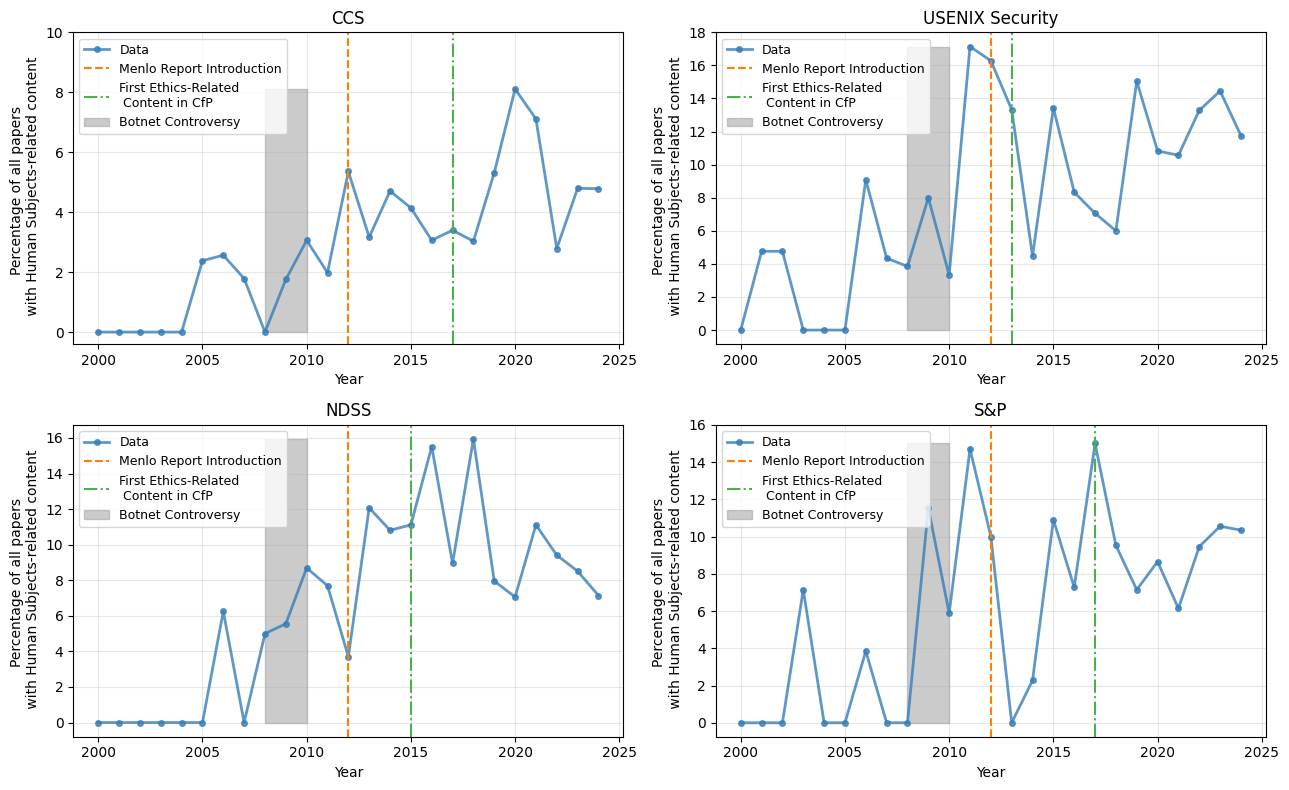

In [13]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.style.use('tableau-colorblind10')
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

column = "human_subject" + "_share"

conferences = ["ccs", "uss", "ndss", "sp"]

cfp_ethics_intro = {"ccs": 2017, "uss": 2013, "ndss": 2015, "sp":2017}
conf_names = {"ccs": "CCS", "uss": "USENIX Security", "ndss": "NDSS", "sp":"S&P"}

calc_changepoints = False

fig, axes = plt.subplots(2, 2, figsize=(13, 8))
axes = axes.flatten()

for k, conference in enumerate(conferences):
    if conference == "all":
        year_dict = year_aggregate(paper_df, colskip=2)
        year_df = pd.DataFrame(year_dict)
    else:
        year_dict = year_aggregate(paper_df, colskip=2)
        year_df = pd.DataFrame(year_dict).groupby("conference").get_group(conference)
    year_df.year = year_df.year.astype(int)
    
    ax = axes[k]
    ax.plot(year_df.year.values, year_df[column].values*100, 'o-', linewidth=2, markersize=4,
             alpha=0.8, label='Data', color=CB_color_cycle[0])
    ax.axvline(x=2012, linestyle='dashed', label=f"Menlo Report Introduction", color=CB_color_cycle[1])
    ax.axvline(x=cfp_ethics_intro[conference], linestyle='dashdot', label=f"First Ethics-Related \n Content in CfP", color=CB_color_cycle[2])
    ax.fill_between(year_df.year.values,min(year_df[column].values), max(year_df[column].values)*100, where=(year_df.year.values < 2011) & (year_df.year.values > 2007), alpha=0.5, label="Botnet Controversy", color=CB_color_cycle[6])

    xticks_range = 5
    yticks_range = 2
    xticks = np.arange(round(year_df.year.values[0]/xticks_range) * xticks_range, round(year_df.year.values[-1]/xticks_range) * xticks_range + xticks_range, xticks_range)
    yticks = np.arange(min(year_df[column].values*100), max(year_df[column].values*100) + yticks_range, yticks_range)

    ax.set_title(conf_names[conference])
    ax.set_xlabel('Year')
    ax.set_ylabel(f'Percentage of all papers \n with Human Subjects-related content')
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left", prop={'size': 9})
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
plt.tight_layout()
plt.savefig("pics/human_subjects_over_time.pdf", format="pdf")  
plt.show()

In [8]:
cols = ["botnet", "ethics_botnet"]
year_dict = {"year":[], "conference": [], "total_paper": []}
for col in cols:
    col_name = col+"_sum"
    year_dict[col_name] = []

year_group = paper_df.groupby("year")
years = year_group.groups.keys()
for y in years:
    year_snippet = year_group.get_group(y)
    conf_group = year_snippet.groupby("conference")
    confs = conf_group.groups.keys()
    for c in confs:
        year_dict["year"].append(y)
        year_dict["conference"].append(c)
        conf_snippet = conf_group.get_group(c)
        paper_total_conf_year = conf_snippet.shape[0]
        year_dict["total_paper"].append(paper_total_conf_year)
        for col in cols:
            col_sum = sum(conf_snippet[col])
            col_name = col+"_sum"
            year_dict[col_name].append(col_sum)
year_df_all_confs = pd.DataFrame(year_dict)
year_df_all_confs[f"{cols[0]}_share"] = year_df_all_confs[cols[0]+"_sum"]/year_df_all_confs.total_paper
year_df_all_confs[f"{cols[1]}_share"] = year_df_all_confs[cols[1]+"_sum"]/year_df_all_confs[cols[0]+"_sum"]
year_df_all_confs = year_df_all_confs.fillna(0)

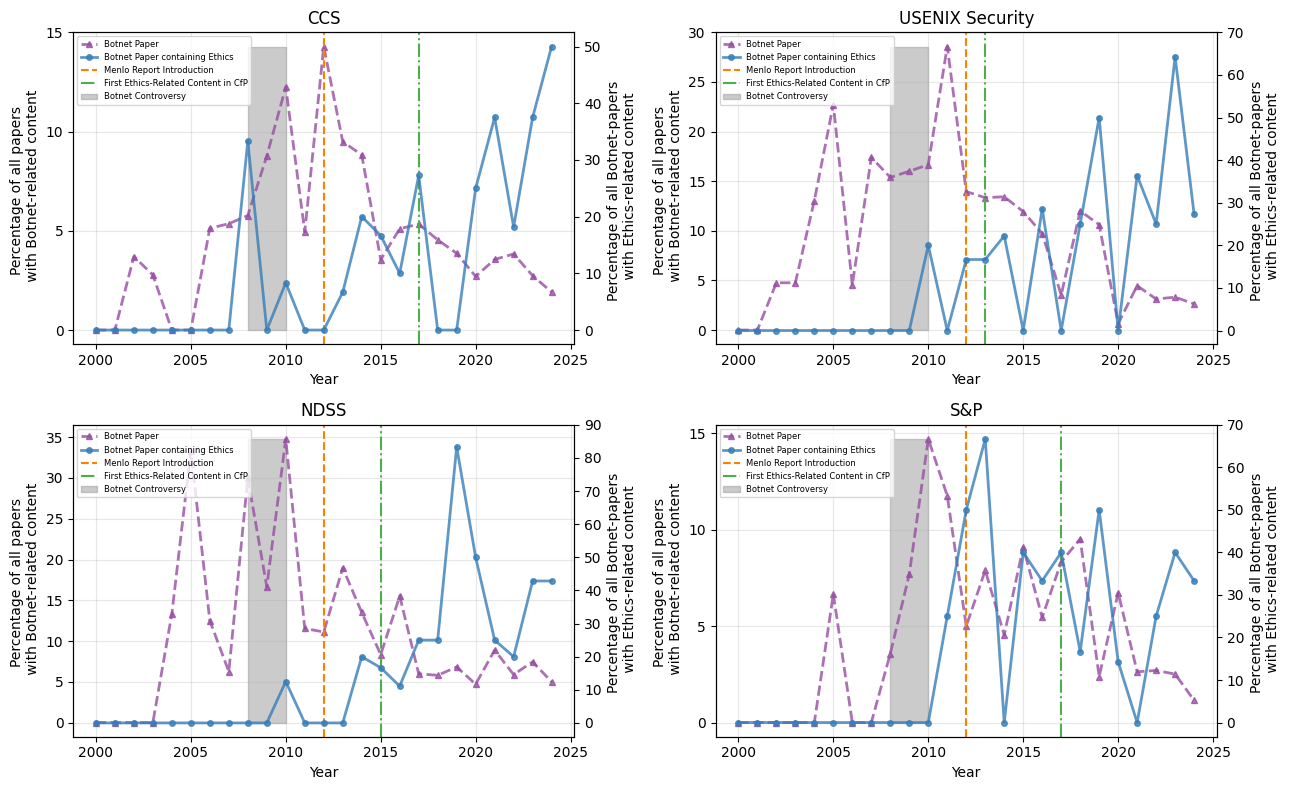

In [9]:
column = cols[0]+"_share"
column2 = cols[1]+"_share"
conferences = ["ccs", "uss", "ndss", "sp"]

cfp_ethics_intro = {"ccs": 2017, "uss": 2013, "ndss": 2015, "sp":2017}
conf_names = {"ccs": "CCS", "uss": "USENIX Security", "ndss": "NDSS", "sp":"S&P"}

fig, axes = plt.subplots(2, 2, figsize=(13, 8))
axes = axes.flatten()

for k, conference in enumerate(conferences):
    year_df = year_df_all_confs.groupby("conference").get_group(conference)
        
    ax = axes[k]
    ax2 = ax.twinx()
    element1 = ax.plot(year_df.year.values, year_df[column].values*100, '^--', linewidth=2, markersize=4,
                       alpha=0.8, label='Botnet Paper', color=CB_color_cycle[5])
    element2 = ax2.plot(year_df.year.values, year_df[column2].values*100, 'o-', linewidth=2, markersize=4,
                        alpha=0.8, label='Botnet Paper containing Ethics', color=CB_color_cycle[0])

    element3 = ax.axvline(x=2012, linestyle='dashed', label=f"Menlo Report Introduction", color=CB_color_cycle[1])
    element4 = ax.axvline(x=cfp_ethics_intro[conference], linestyle='dashdot', label=f"First Ethics-Related Content in CfP", color=CB_color_cycle[2])
    element5 = ax.fill_between(year_df.year.values,min(year_df[column].values), max(year_df[column].values)*100, where=(year_df.year.values < 2011) & (year_df.year.values > 2007), alpha=0.5, label="Botnet Controversy", color=CB_color_cycle[6])
    elements = element1+element2+[element3]+[element4]+[element5]
    labs = [l.get_label() for l in elements]
    
    xticks_range = 5
    yticks_range = 5
    ax.set_title(conf_names[conference])
    ax.set_xlabel('Year')
    ax.set_ylabel(f'Percentage of all papers \n with Botnet-related content')
    ax2.set_ylabel(f'Percentage of all Botnet-papers \n with Ethics-related content')
    ax.grid(True, alpha=0.3)
    ax.legend(elements,labs,loc="upper left", prop={'size': 6})
    ax.set_xticks(np.arange(round(year_df.year.values[0]/xticks_range) * xticks_range, round(year_df.year.values[-1]/xticks_range) * xticks_range + xticks_range, xticks_range))
    ax.set_yticks(np.arange(min(year_df[column].values*100), max(year_df[column].values*100) + yticks_range, yticks_range))
    ax2.set_yticks(np.arange(min(year_df[column2].values*100), max(year_df[column2].values*100) + 10, 10))
plt.tight_layout()
plt.savefig("pics/botnet_over_time.pdf", format="pdf")
plt.show()